In [2]:
from typing import Set, Callable, List

from Ballot import Ballot
from CandidateModel import CandidateModel
from DefaultConfigOptions import *
from Election import Election
from ElectionResult import ElectionResult
from HeadToHeadElection import HeadToHeadElection
from InstantRunoffElection import InstantRunoffElection
from NDPopulation import NDPopulation
import pickle
from ModelStats import ModelStats
from ProcessResult import ProcessResult

TypeError: 'Candidate' object is not subscriptable

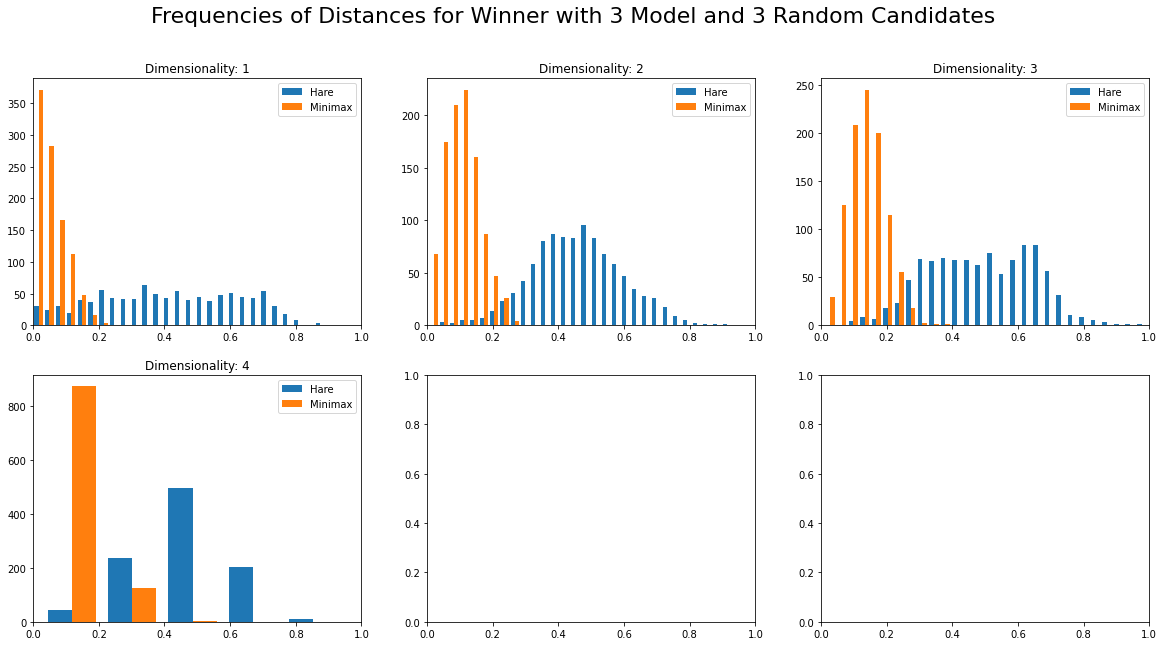

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np

def load_path(path: str) -> any:
    with open(path, "rb") as f:
        return pickle.load(f)

def plot_one_process(results: List[List[Candidate]], title: str):
    n_plots = len(results)

    if n_plots == 3:
        nrows = 1
        ncols = 3
        figsize = (20, 10)
    else:
        nrows = 2
        ncols = 2
        figsize = (20,20)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")
    count = 0
    for winners in results:
        if n_plots == 3:
            axis = axes[count]
        else:
            axis = axes[count // 2][count % 2]

        count += 1

        axis.tick_params(axis='x', colors="black")
        axis.tick_params(axis='y', colors="black")
        axis.set_xlim([0, .1])

        values = [ c.ideology.distance_from_o() for c in winners]

        axis.hist(values, bins=100, label=["Hare", "Minimax"])
        axis.set_title("Dimensionality: %d" % count, color="black")

        axis.legend()

def plot_both_results(irv_results: List[List[Candidate]], h2h_results: List[List[Candidate]], title: str):
    n_plots = len(irv_results)

    nrows = 2
    ncols = 3
    figsize = (20, 10)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")
    count = 0
    for ir, hr in zip(irv_results, h2h_results):
        axis = axes[count // ncols][count % ncols]

        count += 1

        axis.tick_params(axis='x', colors="black")
        axis.tick_params(axis='y', colors="black")
        axis.set_xlim([0, 1.0])

        iv = [ c.ideology.distance_from_o() for c in ir]
        hv = [ c.ideology.distance_from_o() for c in hr]

        axis.hist([iv, hv], bins=30, label=["Hare", "Minimax"])
        axis.set_title("Dimensionality: %d" % count, color="black")

        axis.legend()


def filter_results(pr: ProcessResult) -> ProcessResult :
    rr = [r for r in pr.stats.winners if r[0].name[0] == 'm']
    ms = ModelStats()
    for r in rr:
        ms.update(r[0], r[1])
    return ProcessResult(pr.process, pr.bins, pr.dim, ms)


def make_plots():

    count = 0
    # irv_results = [r for r in results if r.process.name == "Instant Runoff"]
    # h2h_results = [r for r in results if r.process.name == "Head-to-Head"]

    irv_results: List[ProcessResult] = [load_path(s) for s in glob.glob("saved_results-18/Hare*6000.p")][0:4]
    h2h_results: List[ProcessResult] = [load_path(s) for s in glob.glob("saved_results-18/Minimax*6000.p")][0:4]

    irv_results.sort(key=lambda x: x.dim)
    h2h_results.sort(key=lambda x: x.dim)

    def winners(results: ProcessResult) -> List[Candidate]:
        return results.stats.winners

    def get_candidates(results: ProcessResult) -> List[Candidate]:
        candidates: List[Candidate] = []
        for w, cc in zip(results.stats.winners, results.stats.candidates):
            mc = [c for c in cc if c.name[0] == 'm']
            candidates  += mc
        return candidates

    plot_both_results(
        [winners(ir) for ir in irv_results],
        [winners(hr) for hr in h2h_results],
        "Frequencies of Distances for Winner with 3 Model and 3 Random Candidates")

    # plot_one_process(
    #     [winners(ir) for ir in irv_results],
    #     "Frequencies of Distances with Hare")
    #
    # plot_one_process(
    #     [winners(hr) for hr in h2h_results],
    #     "Frequencies of Distances with Minimax")

    filtered_irv = [filter_results(ir) for ir in irv_results]
    filtered_h2h = [filter_results(hr) for hr in h2h_results]

    plot_both_results(
        [winners(ir) for ir in filtered_irv],
        [winners(hr) for hr in filtered_h2h],
        "Frequencies of Distances for Winner with 3 Model and 3 Random Candidates")

    print_stats(irv_results, h2h_results)

make_plots()

In [6]:

def print_stats():
    def min_distance(cc: List[Candidate]) -> float:
        x: float = np.min([c.ideology.distance_from_o() for c in cc])
        return x

    irv_results: List[ProcessResult] = [load_path(s) for s in glob.glob("saved_results-18/Hare*6000.p")][0:4]
    h2h_results: List[ProcessResult] = [load_path(s) for s in glob.glob("saved_results-18/Minimax*6000.p")][0:4]

    irv_results.sort(key=lambda x: x.dim)
    h2h_results.sort(key=lambda x: x.dim)
    print("Results for candidates drawn randomly from the population")
    print("Dimensionality  Best       Hare       Minimax")
    for ir, hr in zip(irv_results, h2h_results):
        dim = ir.dim
        irv_winner_distance = [w.ideology.distance_from_o() for w in ir.stats.winners]
        h2h_winner_distance = [w.ideology.distance_from_o() for w in hr.stats.winners]
        best_candidate = [min_distance(cc) for cc in hr.stats.candidates]

        print("%d             " % dim, end = "")
        print("%5.2f       " % np.mean(best_candidate), end="")
        print("%5.2f       " % np.mean(irv_winner_distance), end ="")
        print("%5.2f       " % np.mean(h2h_winner_distance))


print_stats()

Results for candidates drawn randomly from the population
Dimensionality  Best       Hare       Minimax
1              0.03        0.41        0.06       
2              0.09        0.46        0.11       
3              0.12        0.49        0.14       
4              0.13        0.49        0.16       
